In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, models
import torch
import numpy as np

import os
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

**Konstantos**


1.   ```LOAD_CHECKPOINT``` - switch to True to load existing checkpoint from path
2.   ```USE_SUBSET``` - switch to True to use a part of dataset (useful for testing purposes)
3. ```TRAIN_SUBSET_SIZE``` - define size of train part of dataset
4. ```VALID_SUBSET_SIZE``` - define a size of test part of dataset

**WARNING!!! IMPORTANT!!!**


1.   Jei norite bandyti trainint (patestuot) ir nežinote ar gerai bus, geriausia pakeiskite ```CHECKPOINT_FILENAME``` į kokį nors kitą, kad neprarastume rezultatus. ```checkpoint_poultry``` checkpointa naudokime kaip final versiją.



In [2]:
FEATURE_EXTRACTION = True
CLASS_LIST = ["healthy", "salmo", "cocci", "ncd"]
CLASS_INDICES = {'healthy': 0, 'salmo': 1, 'cocci': 2, 'ncd': 3}
EPOCH_COUNT = 50
TO_RECOGNIZE = 5

TRAIN_PART = 0.8
LEARNING_RATE = 1e-3
PATIENCE = 12

LOAD_CHECKPOINT = False
ROOT_DIR = "../data"
CHECKPOINT_FILENAME = "./checkpoint_poultry.tar"

USE_SUBSET = False
TRAIN_SUBSET_SIZE = 50 * len(CLASS_LIST)
VALID_SUBSET_SIZE = 15 * len(CLASS_LIST)

device = torch.device('mps')
device

device(type='mps')

**Some helper functions**

In [3]:
def seconds_to_time(seconds):
    s = int(seconds) % 60
    m = int(seconds) // 60
    if m < 1:
        return f'{s}s'
    h = m // 60
    m = m % 60
    if h < 1:
        return f'{m}m{s}s'
    return f'{h}h{m}m{s}s'

In [4]:
def load_checkpoint(filename, model, optimizer):
    print("Loading checkpoint...")
    print(filename)
    checkpoint = torch.load(filename)

    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

    training_history = {
        "epoch": checkpoint.get("epoch", 0),
        "train_loss_history": checkpoint.get("train_loss_history", []),
        "accuracy_history": checkpoint.get("accuracy_history", []),
        "train_accuracy_history": checkpoint.get("train_accuracy_history", []),
        "val_loss_history": checkpoint.get("val_loss_history", []),
        "precision_history": checkpoint.get("precision_history", []),
        "recall_history": checkpoint.get("recall_history", []),
        "f1_score_history": checkpoint.get("f1_score_history", []),
        "stats_history": checkpoint.get("stats_history", []),
        "conf_matrix": checkpoint.get("conf_matrix", [])
    }

    return training_history

**Early stopping**

In [5]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

**Vištų šūdukų datasetas paruoštas klasifikavimo uždaviniui**
        

In [6]:
from poultry_dataset import PoultryDatasetClassification

def create_datasets(root_dir, data_classes, test_size=0.2, random_state=42):
    image_paths = []
    labels = []
    class_indices = {data_class: i for i, data_class in enumerate(data_classes)}

    for data_class in data_classes:
        images_dir = f"{root_dir}/{data_class}"
        print(images_dir)
        if not os.path.exists(images_dir):
            print(f"Directory does not exist: {images_dir}")
            continue

        for img in os.listdir(images_dir):
            if img.endswith(".jpg"):
                image_paths.append(os.path.join(images_dir, img))
                label = [0] * len(data_classes)
                label[class_indices[data_class]] = 1
                labels.append(label)

    # Split data while keeping the distribution of classes consistent
    img_train, img_test, labels_train, labels_test = train_test_split(
        image_paths, labels, test_size=test_size, random_state=random_state, stratify=labels
    )

    # Applying transformations
    transform_train = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])


    transform_test = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Creating dataset objects for training and testing
    train_dataset = PoultryDatasetClassification(img_train, labels_train, transform=transform_train)
    test_dataset = PoultryDatasetClassification(img_test, labels_test, transform=transform_test)

    return train_dataset, test_dataset


In [7]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()

    running_train_loss = np.array([], dtype=np.float32)
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels_as_indices = torch.argmax(labels, dim=1)

        outputs = model(images)

        loss = criterion(outputs, labels_as_indices)
        running_train_loss = np.append(running_train_loss, loss.cpu().detach().numpy())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predicted = torch.argmax(outputs, axis = 1)
        correct_predictions += (predicted == labels_as_indices).sum().item()
        total_predictions += labels_as_indices.size(0)

    train_loss = np.mean(running_train_loss)
    train_accuracy = correct_predictions / total_predictions

    return train_loss, train_accuracy

**Skaičiuojamos metrikos visiems predictionams**

In [8]:
def calculate_metrics(correct_predictions, total_predictions, y_true, y_pred):
    print('Total predictions: ', total_predictions)
    print('Correct predictions: ', correct_predictions)

    accuracy = correct_predictions / total_predictions
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred)

    return accuracy, precision, recall, f1, conf_matrix

**Skaičiuojamos metrikos kiekvienai klasei su pasirinktu threshold**

In [9]:
def calculate_metrics_per_class(all_confidences, all_true_labels, threshold=0.8):
    num_classes = all_true_labels.shape[1]
    stats = {}
    for class_index in range(num_classes):
        predictions = (all_confidences[:, class_index] >= threshold).astype(int)

        true_labels = all_true_labels[:, class_index].astype(int)

        TP = np.sum((predictions == 1) & (true_labels == 1))
        TN = np.sum((predictions == 0) & (true_labels == 0))
        FP = np.sum((predictions == 1) & (true_labels == 0))
        FN = np.sum((predictions == 0) & (true_labels == 1))

        accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        stats[class_index] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score
        }

    return stats

**Evaluation loop'as**

In [10]:
def evaluate_epoch(model, test_loader, criterion, optimizer):
    model.eval()
    running_val_loss = np.array([], dtype = np.float32)
    correct_predictions, total_predictions = 0, 0
    y_true, y_pred, all_confidences, all_true_labels = [], [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            labels_as_indices = torch.argmax(labels, axis=1).to(device)

            outputs = model(images)

            confidences = torch.sigmoid(outputs)

            val_loss = criterion(outputs, labels_as_indices)
            running_val_loss = np.append(running_val_loss, val_loss.cpu().detach().numpy())

            predicted = torch.argmax(outputs, axis = 1)

            correct_predictions += (predicted == labels_as_indices).sum().item()
            total_predictions += labels_as_indices.size(0)

            y_true.extend(labels_as_indices.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            all_confidences.extend(confidences.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    all_confidences = np.array(all_confidences)
    all_true_labels = np.array(all_true_labels)

    stats = calculate_metrics_per_class(all_confidences, all_true_labels, threshold=0.5)

    for class_index, class_stats in stats.items():
        print(f"Class {class_index}:")
        print(f" Accuracy: {class_stats['accuracy']}")
        print(f" Precision: {class_stats['precision']}")
        print(f" Recall: {class_stats['recall']}")
        print(f" F1 Score: {class_stats['f1_score']}")

    return np.mean(running_val_loss), correct_predictions, total_predictions, y_true, y_pred, stats

**Pagrindnis loop'as, išsaugom istoriją kad ateityje būtų galima nubraižyt fancy grafikelius**

In [11]:
def train_and_eval(model, loader_train, loader_valid, filename, epoch_count, lr):
  loss_func = torch.nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr = lr)
  early_stopping = EarlyStopping(patience=PATIENCE, min_delta=0.01)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=PATIENCE, verbose=True)
  start_time = datetime.now()

  training_history = None

  if LOAD_CHECKPOINT:
      training_history = load_checkpoint(filename, model, optimizer)
      start_epoch = training_history['epoch'] + 1
      train_loss_history = training_history['train_loss_history']
      accuracy_history = training_history['accuracy_history']
      train_accuracy_history = training_history['train_accuracy_history']
      val_loss_history = training_history['val_loss_history']
      precision_history = training_history['precision_history']
      recall_history = training_history['recall_history']
      f1_score_history = training_history['f1_score_history']
      stats_history = training_history['stats_history']
      conf_matrix = training_history['conf_matrix']
  else:
      start_epoch = 0
      train_loss_history = []
      val_loss_history = []
      accuracy_history = []
      train_accuracy_history = []
      precision_history = []
      recall_history = []
      f1_score_history = []
      stats_history = []
      conf_matrix = []

  for epoch in range(start_epoch, epoch_count):
      print('Starting training epoch... ', epoch)
      start_time = datetime.now()

      train_loss, train_accuracy = train_epoch(model, loader_train, loss_func, optimizer)

      current_time = datetime.now()
      elapsed = seconds_to_time((current_time - start_time).total_seconds())
      print(f'Epoch: {epoch}, Time: {elapsed}, Loss: {train_loss}')

      print('Starting evaluation... ', start_time)
      start_time = datetime.now()

      avg_val_loss, correct_predictions, total_predictions, y_true, y_pred, stats = evaluate_epoch(model, test_loader, loss_func, optimizer)

      accuracy, precision, recall, f1, conf_matrix = calculate_metrics(correct_predictions, total_predictions, y_true, y_pred)

      current_time = datetime.now()
      per_image = (current_time - start_time).total_seconds() / total_predictions
      print(f'Time: {per_image * 1000}ms, Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 score: {f1:.4f}')
      print(f'Confusion matrix: {conf_matrix}')

      accuracy_history.append(accuracy)
      train_accuracy_history.append(train_accuracy)
      train_loss_history.append(train_loss)
      val_loss_history.append(avg_val_loss)
      precision_history.append(precision)
      recall_history.append(recall)
      f1_score_history.append(f1)
      stats_history.append(stats)

      print("Saving checkpoint...")
      checkpoint = {
          "epoch": epoch,
          "state_dict": model.state_dict(),
          "optimizer": optimizer.state_dict(),
          "train_loss_history": train_loss_history,
          "accuracy_history": accuracy_history,
          "train_accuracy_history": train_accuracy_history,
          "val_loss_history": val_loss_history,
          "precision_history": precision_history,
          "recall_history": recall_history,
          "f1_score_history": f1_score_history,
          "stats_history": stats_history,
          "conf_matrix": conf_matrix
      }
      torch.save(checkpoint, filename)

      scheduler.step(avg_val_loss)

      early_stopping(avg_val_loss)
      if early_stopping.early_stop:
          print("Early stopping triggered. Reducing learning rate and resetting early stopping.")
          early_stopping.early_stop = False
          early_stopping.counter = 0

  return training_history


In [12]:
train_dataset, test_dataset = create_datasets(ROOT_DIR, CLASS_LIST)

if USE_SUBSET:
  train_dataset = Subset(train_dataset, range(TRAIN_SUBSET_SIZE))
  test_dataset = Subset(test_dataset, range(VALID_SUBSET_SIZE))

print(f'Train: {len(train_dataset)}, Test: {len(test_dataset)}')

num_workers = 2
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = False)

../data/healthy
../data/salmo
../data/cocci
../data/ncd
Train: 5449, Test: 1363


**ResNet50 model modification**

In [13]:
import torchvision.models.vgg as vgg

def get_model():
    model = vgg.vgg19_bn(weights = vgg.VGG19_BN_Weights.DEFAULT)
    
    # Modify the classifier to match the number of classes
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, len(CLASS_LIST))
    
    return model
    

**Kviečiam mokymą**

In [14]:
model = get_model().to(device)

print(f'Parameter count: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')
training_history = train_and_eval(model, train_loader, test_loader, CHECKPOINT_FILENAME, epoch_count = EPOCH_COUNT, lr = LEARNING_RATE)


Parameter count: 139,597,636
Starting training epoch...  0


/Users/domantas.keturakis/Projects/PoultryDiseaseDetection/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch: 0, Time: 3m50s, Loss: 0.7030833959579468
Starting evaluation...  2024-05-18 21:39:04.520601
Class 0:
 Accuracy: 0.9163609684519443
 Precision: 0.8481308411214953
 Recall: 0.8810679611650486
 F1 Score: 0.8642857142857143
Class 1:
 Accuracy: 0.5891415994130594
 Precision: 0.4460431654676259
 Recall: 0.9538461538461539
 F1 Score: 0.6078431372549019
Class 2:
 Accuracy: 0.9405722670579604
 Precision: 0.8679653679653679
 Recall: 0.9524940617577197
 F1 Score: 0.9082672706681767
Class 3:
 Accuracy: 0.9435069699192957
 Precision: 0.375
 Recall: 0.04
 F1 Score: 0.07228915662650602
Total predictions:  1363
Correct predictions:  1149
Time: 23.0273301540719ms, Epoch 0, Train Loss: 0.7031, Val Loss: 0.5000, Accuracy: 0.8430, Precision: 0.7976, Recall: 0.8430, F1 score: 0.8194
Confusion matrix: [[357  54   1   0]
 [ 29 391  35   0]
 [  5  15 401   0]
 [ 24  40  11   0]]
Saving checkpoint...


/Users/domantas.keturakis/Projects/PoultryDiseaseDetection/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Starting training epoch...  1
Epoch: 1, Time: 3m48s, Loss: 0.5112255811691284
Starting evaluation...  2024-05-18 21:43:28.643956
Class 0:
 Accuracy: 0.8877476155539251
 Precision: 0.7316636851520573
 Recall: 0.9927184466019418
 F1 Score: 0.8424304840370751
Class 1:
 Accuracy: 0.8936170212765957
 Precision: 0.8215767634854771
 Recall: 0.8703296703296703
 F1 Score: 0.8452508004268944
Class 2:
 Accuracy: 0.9728539985326485
 Precision: 0.9660194174757282
 Recall: 0.9453681710213777
 F1 Score: 0.9555822328931572
Class 3:
 Accuracy: 0.9449743213499633
 Precision: 0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1169
Time: 24.09954145267792ms, Epoch 1, Train Loss: 0.5112, Val Loss: 0.5003, Accuracy: 0.8577, Precision: 0.8211, Recall: 0.8577, F1 score: 0.8344
Confusion matrix: [[407   5   0   0]
 [ 79 368   8   0]
 [ 10  17 394   0]
 [ 40  32   3   0]]
Saving checkpoint...


/Users/domantas.keturakis/Projects/PoultryDiseaseDetection/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Starting training epoch...  2
Epoch: 2, Time: 3m51s, Loss: 0.3902032971382141
Starting evaluation...  2024-05-18 21:47:52.851043
Class 0:
 Accuracy: 0.83492296404989
 Precision: 0.647244094488189
 Recall: 0.9975728155339806
 F1 Score: 0.7851002865329512
Class 1:
 Accuracy: 0.942039618488628
 Precision: 0.9541062801932367
 Recall: 0.8681318681318682
 F1 Score: 0.9090909090909092
Class 2:
 Accuracy: 0.9845928099779897
 Precision: 0.9926108374384236
 Recall: 0.9572446555819477
 F1 Score: 0.9746070133010882
Class 3:
 Accuracy: 0.9449743213499633
 Precision: 0.5
 Recall: 0.21333333333333335
 F1 Score: 0.29906542056074764
Total predictions:  1363
Correct predictions:  1172
Time: 23.26223257520176ms, Epoch 2, Train Loss: 0.3902, Val Loss: 0.5919, Accuracy: 0.8599, Precision: 0.8689, Recall: 0.8599, F1 score: 0.8488
Confusion matrix: [[408   2   0   2]
 [ 90 358   1   6]
 [ 19   1 398   3]
 [ 58   8   1   8]]
Saving checkpoint...
Starting training epoch...  3
Epoch: 3, Time: 3m45s, Loss: 0.290

/Users/domantas.keturakis/Projects/PoultryDiseaseDetection/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Starting training epoch...  14
Epoch: 14, Time: 3m16s, Loss: 0.3497353792190552
Starting evaluation...  2024-05-18 22:40:12.704251
Class 0:
 Accuracy: 0.9347028613352898
 Precision: 0.8275862068965517
 Recall: 0.9902912621359223
 F1 Score: 0.901657458563536
Class 1:
 Accuracy: 0.9596478356566398
 Precision: 0.9629629629629629
 Recall: 0.9142857142857143
 F1 Score: 0.9379932356257046
Class 2:
 Accuracy: 0.9677182685253118
 Precision: 0.9198218262806236
 Recall: 0.9809976247030879
 F1 Score: 0.9494252873563219
Class 3:
 Accuracy: 0.9596478356566398
 Precision: 0.6219512195121951
 Recall: 0.68
 F1 Score: 0.6496815286624205
Total predictions:  1363
Correct predictions:  1252
Time: 22.279597212032282ms, Epoch 14, Train Loss: 0.3497, Val Loss: 0.2426, Accuracy: 0.9186, Precision: 0.9159, Recall: 0.9186, F1 score: 0.9141
Confusion matrix: [[403   3   3   3]
 [ 24 408  12  11]
 [  3   4 411   3]
 [ 33   3   9  30]]
Saving checkpoint...
Starting training epoch...  15
Epoch: 15, Time: 3m16s, Los

**Statistiku atvaizdavimas**

Loading checkpoint...
./checkpoint_poultry.tar


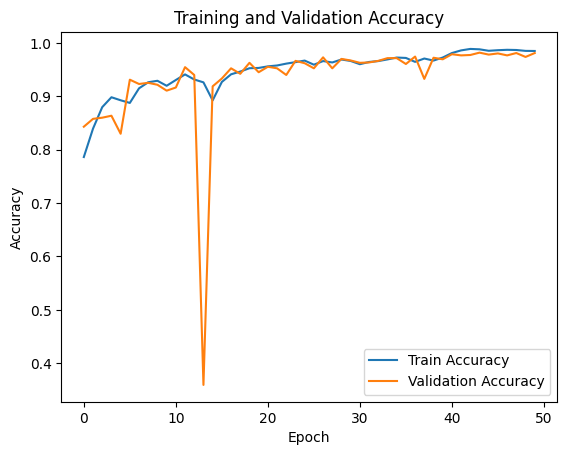

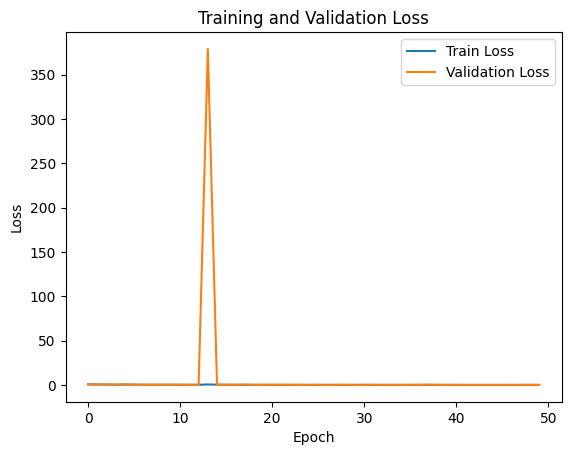

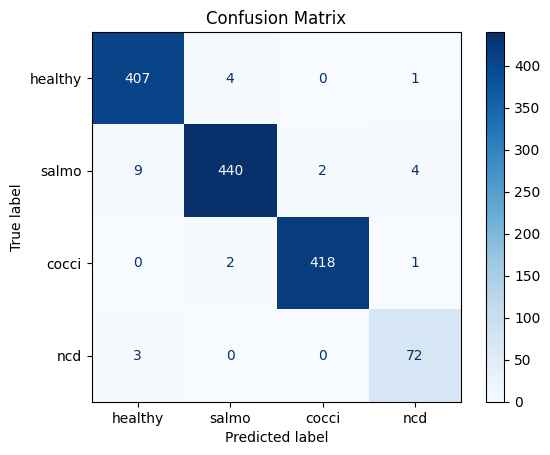

Best epoch based on validation accuracy: 43 with accuracy: 0.9817
Best epoch based on validation loss: 49 with loss: 0.0629


In [15]:
# model = get_model().to(device)
# 
# optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
# 
# training_history = load_checkpoint(CHECKPOINT_FILENAME, model, optimizer)

train_accuracy_history = training_history['train_accuracy_history']
accuracy_history = training_history['accuracy_history']
train_loss_history = training_history['train_loss_history']
val_loss_history = training_history['val_loss_history']
conf_matrix = training_history['conf_matrix']

plt.plot(train_accuracy_history, label='Train Accuracy')
plt.plot(accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

if isinstance(conf_matrix, list):
    last_conf_matrix = np.array(conf_matrix[-1])
else:
    last_conf_matrix = np.array(conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=last_conf_matrix, display_labels=CLASS_LIST)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Finding the epoch with the highest validation accuracy

# Finding the epoch with the lowest validation loss
best_epoch_loss = np.argmin(val_loss_history)
best_val_loss = val_loss_history[best_epoch_loss]

best_epoch_accuracy = np.argmax(accuracy_history)
best_val_accuracy = accuracy_history[best_epoch_accuracy]

print(f'Best epoch based on validation accuracy: {best_epoch_accuracy} with accuracy: {best_val_accuracy:.4f}')
print(f'Best epoch based on validation loss: {best_epoch_loss} with loss: {best_val_loss:.4f}')

**Transformaciju atvaizdavimas**

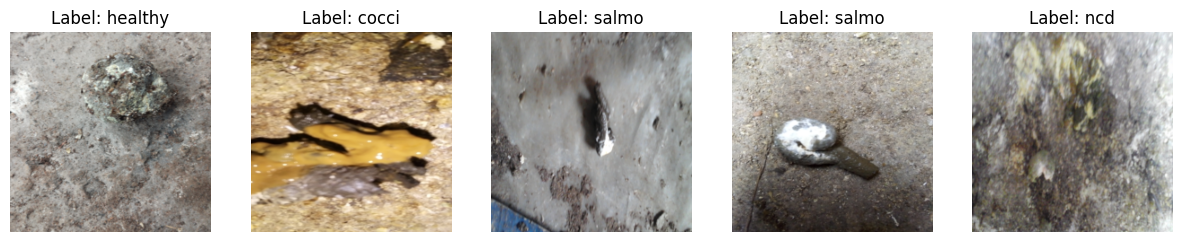

In [16]:
def denormalize(img, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    img = img * std + mean
    return img

def imshow(img, title=None):
    npimg = img.numpy()
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

INDEX_TO_CLASS = {v: k for k, v in CLASS_INDICES.items()}

dataiter = iter(test_loader)
images, labels = next(dataiter)

num_images_to_show = 5
fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 3))
for i in range(num_images_to_show):
    ax = axes[i]
    img = denormalize(images[i], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    npimg = img.numpy()
    npimg = np.clip(npimg, 0, 1)
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    class_index = labels[i].argmax().item()
    class_name = INDEX_TO_CLASS[class_index]
    ax.set_title(f"Label: {class_name}")
    ax.axis('off')
plt.show()
